# Исследование поведения пользователей мобильного приложения

**Описание исследования**

Заказчик -  стартап, который продаёт продукты питания.

**Цель исследования** - изучить воронку продаж и проанаизировать результаты теста. 

**Описание данных**

Входные данные - таблица действий, совершенных пользователями контрольной и экспериментальной группы.

Таблица logs_exp:
1. EventName — название события;
2. DeviceIDHash — уникальный идентификатор пользователя;
3. EventTimestamp — время события;
4. ExpId — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.

**Ход исследования**
 
Перед тем, как непосредственно перейти к анализу данных необходимо провести обзор данных, их предобработку, анализ данных, анализ воронки событий, анализ результатов эксперимента.
 
Таким образом, исследование пройдёт в пять этапов:
 1. Обзор данных.
 2. Предобработка данных.
 3. Исследовательский анализ данных.
 4. Анализ воронки событий.
 5. Анализ результатов эксперимента.

## Обзор данных

In [33]:
# Импортируем необходимые библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import math
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Откроем датасет, в параметре sep укажем \t
data = pd.read_csv('/datasets/logs_exp.csv', sep='\t')

In [3]:
# Получим общую информацию о данных
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


In [4]:
# Проверим датасет на наличие дубликатов
data.duplicated().sum()

413

In [5]:
# Проверим столбцы с категориальными данными на неявные дубликаты
data['EventName'].value_counts()

MainScreenAppear           119205
OffersScreenAppear          46825
CartScreenAppear            42731
PaymentScreenSuccessful     34313
Tutorial                     1052
Name: EventName, dtype: int64

In [6]:
data['ExpId'].unique()

array([246, 248, 247])

**Вывод:** 
- Всего в таблице 4 столбца и 244126 строк.
- Пропусков в таблице не найдено
- В таблице 413 явных дубликатов
- Неявных дубликатов в таблице не найдено
- Необходимо изменить тип данных на datetime в data['EventTimestamp']

## Предобработка данных

In [7]:
# Изменим названия колонок на удобные
data.columns = ['event', 'id', 'datetime', 'group']

In [8]:
# Заменим названия групп на удобные для анализа
data['group'].replace(to_replace= (246,247,248), value = ('A', 'A1', 'B'), inplace=True )

In [9]:
# Изменим тип данных на datetime
data['datetime'] = pd.to_datetime(data['datetime'], unit='s')

In [10]:
# Избавимся от дубликатов
data = data.drop_duplicates()

In [11]:
# Проверим
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 243713 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   event     243713 non-null  object        
 1   id        243713 non-null  int64         
 2   datetime  243713 non-null  datetime64[ns]
 3   group     243713 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 9.3+ MB


**Вывод:**
- Таким образом, были удалены 413 дубликатов
- Изменены названия столбцов, изменены значения строк на удобные
- Изменен тип данных на необходимый в столбце datetime

## Исследовательский анализ данных

In [12]:
# Изучим кол-во событий в логе
data['event'].count()

243713

In [13]:
# Изучим кол-во уникальных пользователей в логе
data['id'].nunique()

7551

In [14]:
# Изучим кол-во событий на пользователя
data.groupby('id')['event'].count().sort_values()

id
6888746892508752          1
4033444713489412517       1
7962370797737085275       1
636273053050387468        1
1918918598819548986       1
                       ... 
1754140665440434215    1221
6932517045703054087    1439
4623191541214045580    1768
197027893265565660     1998
6304868067479728361    2307
Name: event, Length: 7551, dtype: int64

In [15]:
# Изучим среднее кол-во событий на пользователя
data.groupby('id')['event'].count().mean()

32.27559263673685

In [16]:
# Изучим медианное кол-во событий на пользователя
data.groupby('id')['event'].count().median()

20.0

In [17]:
# Найдем минимальную дату
data['datetime'].min()

Timestamp('2019-07-25 04:43:36')

In [18]:
# Найдем максимальную дату
data['datetime'].max()

Timestamp('2019-08-07 21:15:17')

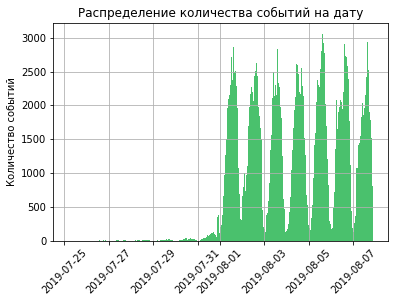

In [19]:
# Построим гистограмму
data['datetime'].hist(bins=312, color=sns.color_palette("viridis")[4])
plt.title('Распределение количества событий на дату')
plt.ylabel('Количество событий')
plt.xticks(rotation=45)
plt.show()

In [20]:
# Избавимся от неактулаьных данных
data = data[(data['datetime'] > '2019-08-01')]

In [21]:
# Проверим
data['datetime'].min()

Timestamp('2019-08-01 00:07:28')

In [22]:
# Проверим много ли событий мы потеряли 
data['event'].count()/243713

0.988404393692581

In [23]:
# Проверим много ли пользователей мы потеряли 
data['id'].nunique()/7551

0.9977486425638988

In [24]:
# Проверим не потеряли ли мы пользователей каждой группы
data.groupby('group')['id'].nunique()

group
A     2484
A1    2513
B     2537
Name: id, dtype: int64

**Вывод:**
- Всего в логе 240887 событий
- Всего пользователей в логе: 7551
- В среднем на пользователя приходится 32 события, однако в логе есть выбивающиеся значения, доходящие до двух тысяч событий
- Медианное кол-во событий на пользователя: 20
- Период лога: с 2019-07-25 по 2019-08-07. Судя по гистограмме наиболее полные данные относятся к периоду с 2019-08-01 по 2019-08-07. Также заметно, что всплеск активности приходится на середину дня.
- Отбросив старые данные, мы потеряли незначительное кол-во информации. Кол-во всех событий снизилось на 2%, кол-во пользователей снизилось на 0.1%.

## Анализ воронки событий

In [25]:
# Определим события в логе и их частоту встречания
data['event'].value_counts()

MainScreenAppear           117328
OffersScreenAppear          46333
CartScreenAppear            42303
PaymentScreenSuccessful     33918
Tutorial                     1005
Name: event, dtype: int64

In [26]:
# Посмотрим сколько пользователей совершали то или иное событие
events = data.groupby('event').agg({'id' : 'nunique'}).sort_values(by='id', ascending=False)
events = events[:-1]
events = events.reset_index()
events

,event,id
0,MainScreenAppear,7419
1,OffersScreenAppear,4593
2,CartScreenAppear,3734
3,PaymentScreenSuccessful,3539


In [27]:
# Найдем долю пользователей, совершивших каждое событие
events['% of initial'] = (events['id']/data['id'].nunique())*100
events

,event,id,% of initial
0,MainScreenAppear,7419,98.473586
1,OffersScreenAppear,4593,60.963632
2,CartScreenAppear,3734,49.561986
3,PaymentScreenSuccessful,3539,46.973719


In [28]:
# Можно предположить, что события проияходят в таком порядке: MainScreenAppear, OffersScreenAppear, CartScreenAppear, PaymentScreenSuccessful, а Tutorial не является обязательным событием и не входит в воронку 
# Далее посчитаем долю пользователей, которые проходят на следующий шаг воронки
events['% of previous'] = ((events['id']/events['id'].shift()).fillna(1))*100
events

,event,id,% of initial,% of previous
0,MainScreenAppear,7419,98.473586,100.000000
1,OffersScreenAppear,4593,60.963632,61.908613
2,CartScreenAppear,3734,49.561986,81.297627
3,PaymentScreenSuccessful,3539,46.973719,94.777718


In [29]:
# Найдем долю пользователей, доходящих от первого события до оплаты
events.loc[3, 'id']/events.loc[0, 'id']

0.47701846610055265

In [35]:
# Построим график, иллюстрирующий воронку событий
df = data.pivot_table(index='event', columns='group', values='id', aggfunc='nunique').reset_index()
df.sort_values('A', ascending=False, inplace=True)    

fig = go.Figure()

fig.add_trace(go.Funnel(
    name = 'Группа A',
    y = df['event'],
    x = df['A'],
    textinfo = "value+percent initial"))

fig.add_trace(go.Funnel(
    name = 'Группа A1',
    orientation = "h",
    y = df['event'],
    x = df['A1'],
    textposition = "inside",
    textinfo = "value+percent initial"))

fig.update_layout(title='Воронка событий для контрольных групп', title_x = 0.5) 

fig.show()   

**Вывод:**
- Судя по частоте встречаемости события происходят в следующем порядке: MainScreenAppear, OffersScreenAppear, CartScreenAppear, PaymentScreenSuccessful, а Tutorial не является обязательным событием и не входит в воронку. Стоит заметить, что событие MainScreenAppear хоть и входит в воронку, не все пользователи проходят через него, следовательно пользователь может перейти к следующему дествию без перехода к главному экрану.
- Судя по доле пользователей, совершивших каждое событие, больше всего пользователей теряется при переходе ко второму шагу (38%).
- Доля пользователей, доходящих от первого события до оплаты: 47,7%.

## Анализ результатов эксперимента

### Стат. анализ результатов АА-теста

In [31]:
# Найдем кол-во пользователей в каждой экспериментальной группе
data.groupby('group')['id'].nunique()

group
A     2484
A1    2513
B     2537
Name: id, dtype: int64

In [32]:
# Проверим нет ли пользователей, попавших в обе группы, посчитаем их долю
np.intersect1d(data.query('group == "A"')['id'].unique(), data.query('group == "B"')['id'].unique())
sum((data[['id', 'group']].drop_duplicates().groupby('id')['group'].count())>1)/len(data)

0.0

In [33]:
np.intersect1d(data.query('group == "A"')['id'].unique(), data.query('group == "A1"')['id'].unique())
sum((data[['id', 'group']].drop_duplicates().groupby('id')['group'].count())>1)/len(data)

0.0

In [34]:
np.intersect1d(data.query('group == "A1"')['id'].unique(), data.query('group == "B"')['id'].unique())
sum((data[['id', 'group']].drop_duplicates().groupby('id')['group'].count())>1)/len(data)

0.0

In [35]:
# Для удобства создадим сводную таблицу с кол-вом пользователей каждой группы, совершивших действия
test = data.query('event != "Tutorial"').pivot_table(index='event', columns='group', values='id', aggfunc='nunique').sort_values(by='A', ascending=False)
test 

group,A,A1,B
event,,,
MainScreenAppear,2450,2476,2493
OffersScreenAppear,1542,1520,1531
CartScreenAppear,1266,1238,1230
PaymentScreenSuccessful,1200,1158,1181


In [36]:
# Необходимо проверить есть ли стат. значимая разница между контрольными выборками, для этого более всего подойдет z-test. Оборнем все рассчеты в функцию.
def check_hypothesis(successes1, successes2, trials1, trials2):
    p1 = successes1/trials1

    p2 = successes2/trials2

    p_combined = (successes1 + successes2) / (trials1 + trials2)

    difference = p1 - p2
    
    z_value = difference / math.sqrt(p_combined * (1 - p_combined) * (1/trials1 + 1/trials2))

    distr = stats.norm(0, 1) 
    
    
    p_value = (1 - distr.cdf(abs(z_value))) * 2

    print('p-значение: ', p_value)

    if (p_value < alpha):
        print("Отвергаем нулевую гипотезу")
    else:
        print("Не получилось отвергнуть нулевую гипотезу")  

In [37]:
# Нулевая гипотеза: стат. значимой разницы между контрольными выборками нет
# Альтернативная гипотеза: контрольные выборки имеют стат. значимую разницу

# Укажем пороговое значение в 5%
alpha = 0.05

In [38]:
# Положим в переменные общее кол-во пользователей в контрольными выборках
users = data.groupby('group')['id'].nunique()
user_a = users[0]
user_a1 = users[1]
user_b = users[2]

# Применим функцию для рассчета z-оценки и p-значения для каждого шага воронки
for event in test.index:
    check_hypothesis(test.loc[event, 'A'], 
                     test.loc[event, 'A1'],
                     user_a,
                     user_a1)

p-значение:  0.7570597232046099
Не получилось отвергнуть нулевую гипотезу
p-значение:  0.2480954578522181
Не получилось отвергнуть нулевую гипотезу
p-значение:  0.22883372237997213
Не получилось отвергнуть нулевую гипотезу
p-значение:  0.11456679313141849
Не получилось отвергнуть нулевую гипотезу


In [41]:
users

group
A     2484
A1    2513
B     2537
Name: id, dtype: int64

**Вывод:**
- Исходя из результатов z-тестов, мы не можем отвергнуть нулевую гипотезу. То есть, мы не можем говорить о том, что группы А и А1 имеют между собой статистически значимое различие на каждом этапе воронки.
- Таким образом, можно сделать вывод, что разбиение на группы работает корректно, так как при граммотном проведении аа-теста показатели между группами отличаться не должны.

### Стат. анализ результатов АБ-теста

In [523]:
# Нулевая гипотеза: стат. значимой разницы между контрольными выборками нет
# Альтернативная гипотеза: контрольные выборки имеют стат. значимую разницу

In [524]:
# С помощью функции сравним выборку А с выборкой Б
for event in test.index:
    check_hypothesis(test.loc[event, 'A'], 
                     test.loc[event, 'B'],
                     user_a,
                     user_b)

p-значение:  0.2949721933554552
Не получилось отвергнуть нулевую гипотезу
p-значение:  0.20836205402738917
Не получилось отвергнуть нулевую гипотезу
p-значение:  0.07842923237520116
Не получилось отвергнуть нулевую гипотезу
p-значение:  0.2122553275697796
Не получилось отвергнуть нулевую гипотезу


In [525]:
# С помощью функции сравним выборку А1 с выборкой Б
for event in test.index:
    check_hypothesis(test.loc[event, 'A1'], 
                     test.loc[event, 'B'],
                     user_a1,
                     user_b)

p-значение:  0.4587053616621515
Не получилось отвергнуть нулевую гипотезу
p-значение:  0.9197817830592261
Не получилось отвергнуть нулевую гипотезу
p-значение:  0.5786197879539783
Не получилось отвергнуть нулевую гипотезу
p-значение:  0.7373415053803964
Не получилось отвергнуть нулевую гипотезу


In [526]:
# Чтобы далее сравнить объединенные выборки просуммируем кол-во пользователей из контрольных групп
test['A+A1'] = test['A']+test['A1']
test

group,A,A1,B,A+A1
event,,,,
MainScreenAppear,2450,2476,2493,4926
OffersScreenAppear,1542,1520,1531,3062
CartScreenAppear,1266,1238,1230,2504
PaymentScreenSuccessful,1200,1158,1181,2358


In [527]:
# С помощью функции сравним объединенные контрольные группы с выборкой Б
for event in test.index:
    check_hypothesis(test.loc[event, 'A+A1'], 
                     test.loc[event, 'B'],
                     (user_a+user_a1),
                     user_b)

p-значение:  0.29424526837179577
Не получилось отвергнуть нулевую гипотезу
p-значение:  0.43425549655188256
Не получилось отвергнуть нулевую гипотезу
p-значение:  0.18175875284404386
Не получилось отвергнуть нулевую гипотезу
p-значение:  0.6004294282308704
Не получилось отвергнуть нулевую гипотезу


**Вывод:**
- Мы не можем отвергнуть нулевую гипотезу при статистической проверке групп А и Б на всех шагах воронки, то есть мы не можем говорить о том, что между двумя группами есть статистически значимое различие
- Мы не можем отвергнуть нулевую гипотезу при статистической проверке групп А1 и Б на всех шагах воронки, то есть мы не можем говорить о том, что между двумя группами есть статистически значимое различие
- Мы не можем отвергнуть нулевую гипотезу при статистической проверке объединенных контрольных групп (А и А1) и группы Б на всех шагах воронки, то есть мы не можем говорить о том, что между двумя группами есть статистически значимое различие

### Перепроверка с другим значением alpha

In [533]:
# Так как нами было проверено 12 гипотез, вероятность получить ложный результат существенно возросла.
# Перепроверим результаты с другим значением alpha, равным 0.5/12 по методу Бонферрони

alpha = 0.5/12

In [534]:
# Применим функцию для рассчета z-оценки и p-значения для каждого шага воронки среди групп А и А1
for event in test.index:
    check_hypothesis(test.loc[event, 'A'], 
                     test.loc[event, 'A1'],
                     user_a,
                     user_a1)

p-значение:  0.7570597232046099
Не получилось отвергнуть нулевую гипотезу
p-значение:  0.2480954578522181
Не получилось отвергнуть нулевую гипотезу
p-значение:  0.22883372237997213
Не получилось отвергнуть нулевую гипотезу
p-значение:  0.11456679313141849
Не получилось отвергнуть нулевую гипотезу


In [535]:
# С помощью функции сравним выборку А с выборкой Б
for event in test.index:
    check_hypothesis(test.loc[event, 'A'], 
                     test.loc[event, 'B'],
                     user_a,
                     user_b)

p-значение:  0.2949721933554552
Не получилось отвергнуть нулевую гипотезу
p-значение:  0.20836205402738917
Не получилось отвергнуть нулевую гипотезу
p-значение:  0.07842923237520116
Не получилось отвергнуть нулевую гипотезу
p-значение:  0.2122553275697796
Не получилось отвергнуть нулевую гипотезу


In [536]:
# С помощью функции сравним выборку А1 с выборкой Б
for event in test.index:
    check_hypothesis(test.loc[event, 'A1'], 
                     test.loc[event, 'B'],
                     user_a1,
                     user_b)

p-значение:  0.4587053616621515
Не получилось отвергнуть нулевую гипотезу
p-значение:  0.9197817830592261
Не получилось отвергнуть нулевую гипотезу
p-значение:  0.5786197879539783
Не получилось отвергнуть нулевую гипотезу
p-значение:  0.7373415053803964
Не получилось отвергнуть нулевую гипотезу


In [537]:
# С помощью функции сравним объединенные контрольные группы с выборкой Б
for event in test.index:
    check_hypothesis(test.loc[event, 'A+A1'], 
                     test.loc[event, 'B'],
                     (user_a+user_a1),
                     user_b)

p-значение:  0.29424526837179577
Не получилось отвергнуть нулевую гипотезу
p-значение:  0.43425549655188256
Не получилось отвергнуть нулевую гипотезу
p-значение:  0.18175875284404386
Не получилось отвергнуть нулевую гипотезу
p-значение:  0.6004294282308704
Не получилось отвергнуть нулевую гипотезу


**Вывод:**

Как видно, результаты новой проверки не отличаются от предыдущей. Следовательно мы не можем утверждать, что показатели разных групп как либо различаются на каждом шаге.

## Общий вывод

Таким образом, исследование было выполнено в 5 этапов:
1. Обзор данных. На этом этапе был распакован датасет, изучен на предмет пропусков и аномалий.
2. Предобработка данных. На этом этапе данные были отчищены от дубликатов, названия и некоторые значения строк изменены на удобные. Изменен тип данных в колонке datetime на необходимый.
3. Анализ данных. На этом этапе были изучены основные данные в датасете: кол-во уникальных пользователей, кол-во событий в логе, изучаемый период и др. 
4. Анализ воронки событий. На данном этапе были изучены события в логе, частота их встречаемости, порядок, доля и другие показатели. 
5. Анализ результатов эксперимента. На данном этапе был проведен стат. анализ результатов АА-теста и АБ-теста, также была произведена перепроверка.

**Анализ воронки событий: выводы**
- Судя по частоте встречаемости события происходят в следующем порядке: MainScreenAppear, OffersScreenAppear, CartScreenAppear, PaymentScreenSuccessful, а Tutorial не является обязательным событием и не входит в воронку.
- Судя по доле пользователей, совершивших каждое событие, больше всего пользователей теряется при переходе ко второму шагу (38%).
- Доля пользователей, доходящих от первого события до оплаты: 47,7%

**Анализ результатов эксперимента: выводы**
- Разбиение на группы А и А1 работает корректно. Показатели групп не имеют между собой статистически значимых различий на каждом шаге воронки.
- Судя по стат. тесту и его перепроверке мы не можем утверждать, что показатели групп А и Б, групп А1 и Б и объединенной контрольной группы и группы Б статистически значимо различаются на каком-либо из шагом. Это может говорить только о том, что **А/Б тест не показал каких-либо положительных или отрицательных результатов**.